#0) Player Gameplay Data Preprocessing

##a) Retriever Player Data (Data Redacted for Confidentiality)

In [3]:
import numpy as np
import pandas as pd
import ast
import math
import os
import sys
import random
from gym import core, spaces
import matplotlib.pyplot as plt
from collections import Counter

#!pip install optuna #this is for parameter search
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from collections import Counter
from collections import defaultdict

##b) Action Sequence Processing

In [5]:
# Filter out rows where 'action_sequences' is NaN
df = df[~df['action_sequences'].isna()]

Normalize actions within action sequences so they can be taken by step function


In [6]:
import ast
import math

# Convert string representations of lists to actual lists of floats
df['action_sequences'] = df['action_sequences'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Iterate through each value 'val' in 'seq':
# - If 'val' is -0.0 and its sign is negative, return 6.0.
# - If 'val' is less than 0.0 (negative), multiply 'val' by -1 and add 6.
# - Otherwise, return 'val' as is.
# - actions normalized from -5 to 5, to 0-11
def process_sequence(seq):
  return [6.0 if val == -0.0 and math.copysign(1, val) == -1  else (val*-1+6 if val < 0.0 else val) for val in seq]

df['action_sequences'] = df['action_sequences'].apply(process_sequence)


print(df['action_sequences'])


0         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
1         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
2         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
3         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
4         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
                         ...                 
319614    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
319615    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
319616    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
319617    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
319618    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
Name: action_sequences, Length: 319283, dtype: object


In [7]:
#extracts the most recent sequence of actions (action_sequences) for each unique combination of player ID, timestamp, session, and subwave so we are working with the final state of each subwave or session
seqs = df.groupby(["ID","datetime","session_start","sw_number"]).last().reset_index()
seqs['action_sequences']

,action_sequences
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]"
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]"
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]"
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]"
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]"
...,...
63890,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]"
63891,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 6.0]"
63892,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]"
63893,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]"


In [8]:
#transforms the action_sequences column from an allocentric (absolute reference) representation to an egocentric (relative reference) one
def allo_to_ego(action_seq):
    ego_seq = [action_seq[0]] + [
        ((action_seq[i] - action_seq[i - 1]) % 6) + (6 if action_seq[i] >= 6 else 0)
        for i in range(1, len(action_seq))
    ]
    return ego_seq

seqs['action_sequences'] = seqs['action_sequences'].apply(allo_to_ego)
seqs['action_sequences']

,action_sequences
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]"
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]"
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]"
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]"
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]"
...,...
63890,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]"
63891,"[0.0, 0.0, 1.0, 5.0, 0.0, 0.0, 6.0]"
63892,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]"
63893,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]"


##c) Create a gym environment specifying the rules of the game






This class defines the game as a gym environment. The most important functions are:


1.   `ready`, which specifies behaviors of the environtment (e.g., how many levels to play and whether to print out the game state).
2.   `step`, which takes as input the state of the game and the agent's action, and outputs the next state, the reward received in that step, and whether the episode has terminated.

In [9]:
import random
from gym import core, spaces #core creates base class for creating custom gym enviroment, spaces provides classes to define action and observation spaces

class hexxed(core.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        """Initializes constants.
        """
        self.curr_wave = 1
        self.curr_act = 0
        self.num_attempts = 0
        self.wave_reward = 0
        self.max_reward = 0
        # ↓ which subwave in wave
        self.subwave_num = 0
        #self.states_in_time = []

    def ready(self, num_vertices=6, step_per_pattern=6, levels=6,
              shuffle_patterns=True, random_rolls = False,
              normalize_reward = False, perfect_bonus = False,render_mode=1): #only used initially to set enviroment up - only do once
        """Sets hyperparameters as
        1. complexity of the state space - will never change, number of steps will be the same as num lobes
        2. number of levels to be played
        3. data shuffling #shuffle_patterns controls whether the order of the puzzles is shuffled or stays the same each time you play
        4. randomization of initial states
        5. Whether to incentivize getting a perfect solution
        """

        # ↓ initalize x axis
        self.grid_x = num_vertices #num_vertices is how many sides the puzzle has - 6 for our hexagon
        # ↓ how many steps of target growth player can access - how long the target you need to build can grow (default is 6)
        self.cut_off = step_per_pattern
        # ↓ how many levels to attempt
        self.num_levels = levels
        # ↓ total steps of target growth [changes from 12 to 2*num_vertices] - initializes y axis
        self.grid_y = 2 * num_vertices
        # ↓ if true patterns (unshuffled) are shuffled after being loaded
        # IMPORTANT bc determines whether the order in which puzzles appear is randomized - shuffle_patterns controls whether the order of the puzzles is shuffled or stays the same
        self.shuffle_patterns = shuffle_patterns
        # ↓ if true patterns are rolled with random prob
        #IMPORTANT bc different players get different variations of the game (some get standard some get rotated so we see if rotations are on or off and we might need to know the position of the puzzle pieces so we can properly encode the state of the board
        self.random_rolls = random_rolls
        # ↓ if true rewards is non proportional to the level - default is false
        self.normalize_reward = normalize_reward
        # ↓ if 1, prints the state of the game
        self.render_mode = render_mode

        # add an incentive for the network to get maximum score - turned out not to matter that much
        if perfect_bonus: #sets a bonus value of 36 points for getting a perfect score
            self.perfect_bonus = 36
        else:
            self.perfect_bonus = 0 #no bonus if the score is not perfect

        #reads patterns for the current wave (level) from a file and stores them in a list
        self.pattern_list = self.read_patterns(range(self.curr_wave))
        # ↓ shift_by 0..5 vertices, collect
        self.action_space = spaces.Discrete(num_vertices + 1) #discrete space with num_vertices + 1 possible actions, representing different moves a player can make
        # ↓ contains all states
        grid_size = self.grid_x * self.grid_y
        self.observation_space = spaces.Box(np.zeros(grid_size, dtype=np.float32), #continuous space representing the state of the game grid, with values ranging from 0 to 1
                                            np.ones(grid_size, dtype=np.float32), dtype=np.float32)
        self.subwave_id = []
        self.reward_mean = []
        self.level_num = []
        self.attempt_num = []
        self.reward_hist = []
        self.level_hist = []
        self.action_hist = []

    #Iterate over the range of target numbers
    def read_patterns(self, num_targets):
        # Load all patterns from 'spawn.txt' into a NumPy array
        all_patterns = np.loadtxt('spawn.txt','int',delimiter=',')
        patterns = []
        for i in num_targets:
            # Select patterns that match the current level (i+1) from all_patterns
            level_patterns = all_patterns[all_patterns[...,1] == i+1,...]
            #Reshape the selected patterns and append some extra information to them
            level_patterns = np.append(level_patterns[...,0].reshape((-1,i+1)),level_patterns[::i+1,3].reshape((-1,1)),1)

            # If shuffle_patterns is True, shuffle the selected patterns
            if self.shuffle_patterns:
                np.random.shuffle(level_patterns)
            patterns.extend(level_patterns.tolist())
        return patterns

    def get_grid(self):
      return self.grid

    #input action and the game state --> game state is updated step based on inputted action
    def step(self, action):
      if self.render_mode:
        #self.render()
        #if self.curr_wave == 1:
        self.curr_act = action
        self.action_hist.append(action)
        self.subwave_id.append(self.subwave_num)
        #self.states_in_time[self.key].append(deepcopy(self.grid))
        reward = 0
        done = 0
        if action < 6:
            self.step_grid(action)
        else:
          action = action - 6
          if action > 0 or not self.ismoving:
            self.step_grid(action)

          age = np.where(self.grid[0,self.cut_off:])[0]
          if age.size > 0:
              reward = (age[0]+1)*2
              self.grid[0,:] = 0
              #reward = (np.where(self.grid[0,self.cut_off:])[0][0]+1)2
              #print(reward)
              #self.grid[0,:] = 0

        self.ismoving = True
        if self.normalize_reward:
            reward /= 36.0
        done = np.sum(self.grid) == 0
        self.subwave_reward += max(0,reward)
        if done:
            if self.subwave_reward == self.subwave_max:
                self.max_reward += self.perfect_bonus * self.curr_wave
                reward += self.perfect_bonus * self.curr_wave
            self.max_reward += self.pattern_list[self.subwave_num][-1]
            #self.subwave_num = (self.subwave_num  + 1)
        self.wave_reward += max(0,reward)
        self.reward_hist.append(self.subwave_reward)
        self.reward_mean.append(self.wave_reward)
        self.level_hist.append(self.curr_wave)
        self.attempt_num.append(self.num_attempts)
        if self.render_mode:
          print(self.curr_act,end=' ')
          print(self.curr_wave,end=' ')
          print(self.num_attempts,end=' ')
          print(self.subwave_reward)
        return self.grid.flatten(), reward, done, {}

    #updates the game grid based on the action taken by adjusting the position of elements in the grid
    def step_grid(self,vert): # vert is the action that is fed in
        #if self.ismoving is true (player not at inital state of board) calculates distance aka remaining steps needed to reach the target position
        if self.ismoving:
            dist = max(1,min(vert,6-vert)) # finding clockwise or counter clockwise distance is closest (similiar to what i did but just in one line)
        #If the player is not moving (self.ismoving is False), the distance is set to 1, indicating the initial move.
        else:
            dist = 1
        self.grid = np.roll(np.roll(self.grid,-vert,0),dist,1) # and then you're rolling the board accordingly - np.roll rotates the grid by -vert positions along the rows, and the second np.roll rotates by dist positions along the columns
        self.grid[:,:dist] = 0 #makes the game binary, moving things up and erasing the 1

    #initializes or resets the environment to its starting state, preparing it for a new episode.
    def reset(self):
        #if the accumulated reward for the current wave is below a threshold determined by subtracting a value based on the length of the pattern list multiplied by 15 from the maximum reward achieved so far.
        if (self.curr_wave < 6 and self.wave_reward < self.max_reward - len(self.pattern_list)*15) or \
            (self.curr_wave == 6 and self.wave_reward < self.max_reward - len(self.pattern_list)*6):
            self.reset_helper()

        elif self.subwave_num == len(self.pattern_list):
            self.reset_helper()

            if self.curr_wave == self.num_levels:
                self.curr_wave = 1
            else:
                self.curr_wave = min(self.curr_wave+1, self.num_levels)

        #Subwave Initialization
        if self.subwave_num == 0: #if new subwave
            self.pattern_list = self.read_patterns(range(self.curr_wave-1, self.curr_wave)) #load the patterns for the current wave range
            self.wave_reward = 0
            self.max_reward = 0
            self.num_attempts += 1

        #Grid and Pattern Initialization
        self.ismoving = False
        self.subwave_max = self.pattern_list[self.subwave_num][-1]
        self.subwave_reward = 0

        #initializes the game grid (self.grid) as a matrix of zeros with dimensions (self.grid_x, self.grid_y)
        self.grid = np.zeros(shape=(self.grid_x,self.grid_y))
        #populates the grid based on the patterns for the current subwave, setting certain elements to 1 based on the pattern
        for i in range(len(self.pattern_list[self.subwave_num])-1):
            self.grid[self.pattern_list[self.subwave_num][i]][self.cut_off-i-1] = 1

        #If random rolls are enabled (self.random_rolls is True), this part of the code performs random rotations on the grid
        if self.random_rolls:
            self.grid = np.roll(self.grid,random.randint(0, self.grid_x),0)
            if random.randint(0,2):
                self.grid = np.roll(np.flip(self.grid, 0), 1, 0)
        return self.grid.flatten()

    def reset_helper(self):
        #print('num_attempts {}, subwave_num {}, curr_wave {}'.format(self.num_attempts,self.subwave_num,self.curr_wave))
        #self.reward_mean.append(self.wave_reward/self.subwave_num)
        #self.level_num.append(self.curr_wave)
        #self.attempt_num.append(self.num_attempts)
        self.subwave_num = 0

        # Subwave Initialization
        if self.subwave_num == 0:  # If new subwave
            self.pattern_list = self.read_patterns(range(self.curr_wave-1, self.curr_wave))  # Load the patterns for the current wave range
            self.wave_reward = 0
            self.max_reward = 0
            self.num_attempts += 1

        # Grid and Pattern Initialization
        self.ismoving = False
        self.subwave_max = self.pattern_list[self.subwave_num][-1]
        self.subwave_reward = 0

        # Initializes the game grid (self.grid) as a matrix of zeros with dimensions (self.grid_x, self.grid_y)
        self.grid = np.zeros(shape=(self.grid_x, self.grid_y))
        # Populates the grid based on the patterns for the current subwave, setting certain elements to 1 based on the pattern
        for i in range(len(self.pattern_list[self.subwave_num]) - 1):
            self.grid[self.pattern_list[self.subwave_num][i]][self.cut_off-i-1] = 1

        # If random rolls are enabled (self.random_rolls is True), this part of the code performs random rotations on the grid
        if self.random_rolls:
            self.grid = np.roll(self.grid, random.randint(0, self.grid_x), 0)
            if random.randint(0, 2):
                self.grid = np.roll(np.flip(self.grid, 0), 1, 0)

        # Ensure subwave_num is set to 0
        self.subwave_num = 0

        return self.grid.flatten()


    #display the current state of the game environment, particularly the game grid, in a human-readable format
    def render(self, mode='human', close=False):
        if close:
            return
        hexagon = np.zeros(self.grid_x)
        print(' ',end='')
        for x in range(self.grid_x):
            y = np.where(self.grid[x,:])[0]
            if np.size(y):
                hexagon[x] = y[0]
        for x in range(self.grid_x):
            out_val = int(hexagon[x]-5)
            if out_val == -5:
              print('.',end='  ')
            elif out_val < 0:
              print(out_val,end=' ')
            else:
              print(out_val,end='  ')


##d) Generate Gamestate sequences From Action Sequences

85 element vectors represent gamestate (previous action + resulting board state) where the first 72 elements are the OHE board state and the last 13 elements are the players previous action. Below, we generate boardstate for each action within players action sequence, OHE previous position within sequence

this function might take a few minutes to run!

In [10]:
import os
import sys

# Function to get one-hot encoding with reset after 13, this will encode players most current action
def get_one_hot_encoding(position, size=13):
    one_hot = np.zeros(size)
    one_hot[position] = 1
    return one_hot

# Function to process the action sequence and get the board states and positions
def get_board_states_and_positions(actions):
    env = hexxed() #for each action sequence, reset the enviroment so we have a new unmodified board
    env.ready()
    env.reset()
    board_states = []
    board_states.append(np.concatenate((env.get_grid().flatten(), get_one_hot_encoding(0)))) #add the initial board, without any actions taken
    for i, action in enumerate(actions[:-1]): #if our target (players next action) is i, we want board state i-1. 1st action doesnt have a boardstate, so add the inital state and remove last action
        #for each action take a step --> modify board acccordingly
        state,_,_,_ = env.step(int(action))
        one_hot_position = get_one_hot_encoding(int(action+1)) #encode what this action is as a OHE vector
        combined_state = np.concatenate((state, one_hot_position)) #combine board state and action
        board_states.append(combined_state) #add to list for that row
    return board_states


# Suppressing print statements
class SuppressPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Iterate over each row in the 'action_sequences' column and process the sequences
all_board_states = []

#with SuppressPrints():
with SuppressPrints():
    for idx, action_sequence in seqs['action_sequences'].items():
        # This block will suppress any prints within the function calls
        board_states = get_board_states_and_positions(action_sequence)
        all_board_states.append(board_states)
print("Processing done!")


# Add the list of board states and positions as new columns to the DataFrame
seqs['board_states'] = all_board_states

Processing done!


make sure that every action sequence has a cooresponding board state sequence of the same length

In [11]:
# new columns with length of the action sequences and board states
seqs['action_sequence_length'] = seqs['action_sequences'].apply(len)
seqs['board_state_length'] = seqs['board_states'].apply(len)

# Check if lengths match
lengths_match = (seqs['action_sequence_length'] == seqs['board_state_length'])

# show any rows where lengths do not match
mismatch_rows = seqs[~lengths_match]

if not mismatch_rows.empty:
    print("Rows with mismatched lengths:")
    print(mismatch_rows[['action_sequence_length', 'board_state_length']])
else:
    print("All lengths match :p")

All lengths match :p


make sure that all players/attempts have the same inital board state

In [12]:
# Extract the first element of each list in 'board_states' and store it in a new column
seqs['first_board_state'] = seqs['board_states'].apply(lambda x: x[0])

# Calculate the average of the first_board_state
average_first_board_state = seqs['first_board_state'].mean()

print(average_first_board_state)

#check if any states dont have this value
seqs['is_different'] = seqs['first_board_state'].apply(lambda x: not np.array_equal(x,average_first_board_state))

different_states = seqs[seqs['is_different']]

print(different_states[['first_board_state']])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Empty DataFrame
Columns: [first_board_state]
Index: []


In [13]:
# this is a better visualization of what the first board state looks like
first_72_values = average_first_board_state[:72]
reshaped_matrix = first_72_values.reshape(6, 12)
print("Average first 72 values of inital board states:")
print(reshaped_matrix)

Average first 72 values of inital board states:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [14]:
#Make sure we have the correct inital board states
#we have 12 actions, but there is this one hot encoding to represent that no actions have been taken yet
last_13_values = average_first_board_state[-13:]
print("Average last 13 values of inital board states:")
print(last_13_values)

Average last 13 values of inital board states:
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


##e) Define Final Dataframe for Model Input

right now the df contains individual session attempts. we want to make sure that the history of a given ID is grouped together chronologically so our network can train on their entire history.

In [15]:
#run this to make sure we group correcly later

# Counting number of rows for each ID
id_counts = seqs['ID'].value_counts()

# Filtering for IDs that have multiple rows
multiple_row_counts = id_counts[id_counts > 1]
#print(multiple_row_counts)

#total expected rows after combining
expected_rows = len(id_counts)  # each unique ID should have one row in the final DataFrame

# Filtering for IDs that have a single row
single_row_counts = id_counts[id_counts == 1]

# Calculating the number of rows that will remain unchanged
rows_left_same = len(single_row_counts)

print(f"Total rows in 'seqs': {len(seqs)}")
print(f"Unique IDs with multiple rows: {len(multiple_row_counts)}")
print(f"Number of rows that will be left the same (single-row IDs): {rows_left_same}")
print(f"Number of rows that will be combined: {sum(multiple_row_counts) - len(multiple_row_counts)}")
print(f"Total unique IDs (should match final row count in new DataFrame): {expected_rows}")

Total rows in 'seqs': 63895
Unique IDs with multiple rows: 3925
Number of rows that will be left the same (single-row IDs): 91
Number of rows that will be combined: 59879
Total unique IDs (should match final row count in new DataFrame): 4016


combine rows for the same player (ID) in chronological order

In [16]:
#Sort the DataFrame by 'datetime' to ensure chronological order
newseqs = seqs.sort_values(by='datetime')

#Identify unique and duplicate IDs
grouped = newseqs.groupby('ID')
unique_ids_df = grouped.filter(lambda x: len(x) == 1)  # IDs without duplicates
duplicate_ids_df = grouped.filter(lambda x: len(x) > 1)  # IDs with multiple rows

# Create a new DataFrame for IDs without duplicates with only selected columns
unique_df = unique_ids_df[['ID', 'action_sequences', 'board_states', 'learning', 'learned']].copy()

#For IDs with duplicates, combine the columns, make sure they are being added in chronological order
# Aggregate using 'sum' for lists and 'max' for binary/categorical indicators
combined_df = (
    duplicate_ids_df.groupby('ID')
    .agg({
        'action_sequences': 'sum',  # Concatenate lists
        'board_states': 'sum',      # Concatenate lists
        'learning': list,          # Take the max value (e.g., if any row has learning, it's true)
        'learned': list            # Take the max value (e.g., if any row has learned, it's true)
    })
    .reset_index()
)

#Concatenate the unique and combined DataFrames to get the final result
final_df = pd.concat([unique_df, combined_df], ignore_index=True)

In [17]:
#Because we concatonated, we want to shuffle the rows so single atttempt ids are mixed in to the rest

# Shuffle rows of final_df randomly
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [18]:
#double checking that player action sequences were concatonated correctly

# Display 'action_sequence' values for '1593804544_938284352' in 'seqs'
original_sequences = seqs.loc[seqs['ID'] == '1593804544_938284352', 'action_sequences']
print("Original action_sequences in seqs:")
print(original_sequences.tolist())

# Display the combined 'action_sequence' value for '1593804544_938284352' in 'final_df'
combined_sequence = final_df.loc[final_df['ID'] == '1593804544_938284352', 'action_sequences'].values[0]
print("\nCombined action_sequence in final_df:")
print(combined_sequence)

Original action_sequences in seqs:
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]]

Combined action_sequence in final_df:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]


In [19]:
# Check that the length of action_sequences matches the length of board_states for each ID
mismatches = []

for idx, row in final_df.iterrows():
    if len(row['action_sequences']) != len(row['board_states']):
        mismatches.append((row['ID'], len(row['action_sequences']), len(row['board_states'])))

# Print the results
if mismatches:
    print("IDs with mismatched lengths between action_sequences and board_states:")
    for mismatch in mismatches:
        print(f"ID: {mismatch[0]}, action_sequences length: {mismatch[1]}, board_states length: {mismatch[2]}")
else:
    print("All IDs have matching lengths for action_sequences and board_states.")


All IDs have matching lengths for action_sequences and board_states.


filter dataframe so that we only have rows from players who have learning (aka demonstrated a leap of insight at some point in their sequence)

In [20]:
# Find IDs where the 'learned' column contains both True and False - there should be none of these
mixed_learned_ids = final_df[
    final_df['learned'].apply(lambda x: isinstance(x, list) and len(set(x)) > 1)  # makeing sure x is a list before using set()
]

print("IDs with both True and False in 'learned':")
print(mixed_learned_ids[['ID', 'learned']])


IDs with both True and False in 'learned':
Empty DataFrame
Columns: [ID, learned]
Index: []


In [21]:
# making sure all entries in 'learned' are lists for consistent processing
final_df['learned'] = final_df['learned'].apply(lambda x: x if isinstance(x, list) else [x])

# Group by 'ID' and combine the 'learned' values into a single list for each ID
grouped_learned = final_df.groupby('ID')['learned'].sum()

# Counting IDs based on whether they learned or not
ids_learned = sum(1 for learned_list in grouped_learned if True in learned_list)
ids_not_learned = sum(1 for learned_list in grouped_learned if True not in learned_list)

print(f"Number of IDs who have learned: {ids_learned}")
print(f"Number of IDs who have not learned: {ids_not_learned}")


Number of IDs who have learned: 1649
Number of IDs who have not learned: 2367


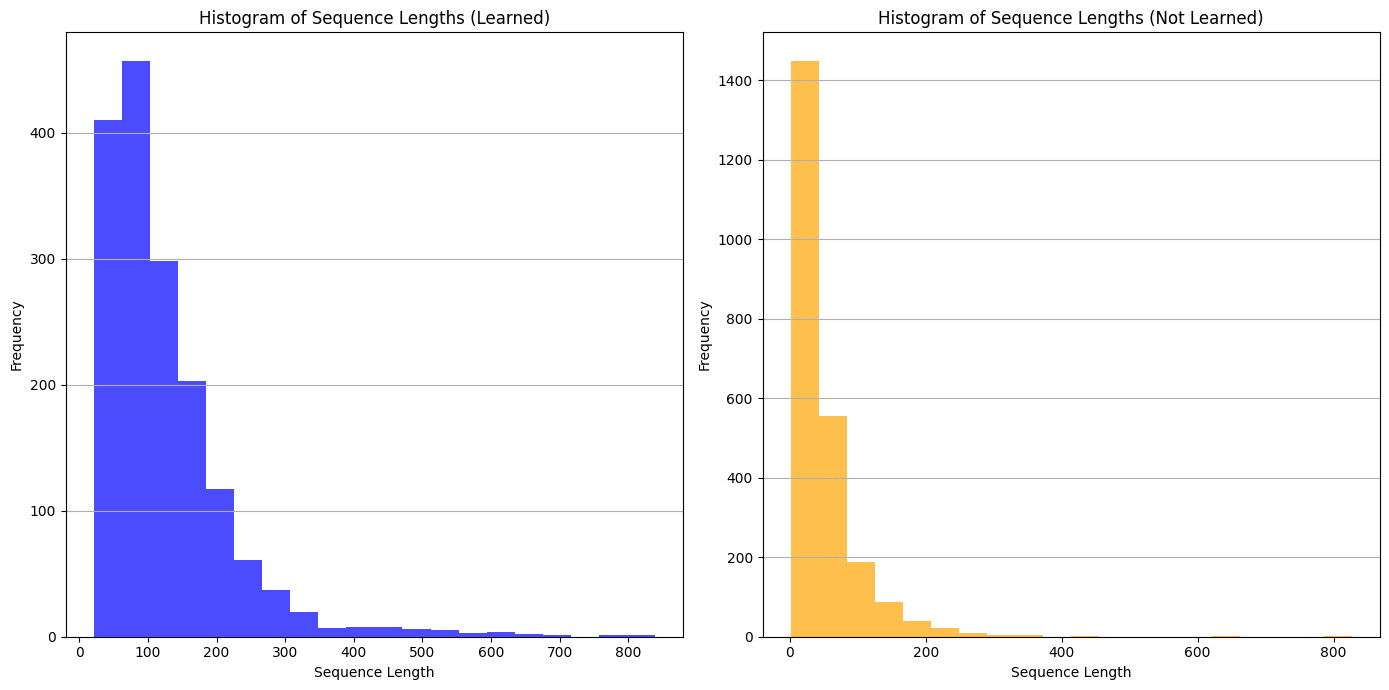

Average sequence length for IDs who have learned: 123.38
Average sequence length for IDs who have not learned: 48.94


In [22]:
#looking to see if there is a difference between lengths of players who have learned and players who have not

# Add a column for the length of each action sequence
final_df['sequence_length'] = final_df['action_sequences'].apply(len)

# Group by 'ID' to determine learning status
grouped_learned = final_df.groupby('ID')['learned'].sum()

# Identify IDs who have learned and not learned
ids_learned = grouped_learned[grouped_learned.apply(lambda x: True in x)].index
ids_not_learned = grouped_learned[grouped_learned.apply(lambda x: True not in x)].index

# Separate sequence lengths for those who have learned and those who have not
learned_sequence_lengths = final_df[final_df['ID'].isin(ids_learned)]['sequence_length']
not_learned_sequence_lengths = final_df[final_df['ID'].isin(ids_not_learned)]['sequence_length']

# Plot histograms
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))

# Histogram for IDs who have learned
plt.subplot(1, 2, 1)
plt.hist(learned_sequence_lengths, bins=20, alpha=0.7, color='blue')
plt.title('Histogram of Sequence Lengths (Learned)')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(axis='y')

# Histogram for IDs who have not learned
plt.subplot(1, 2, 2)
plt.hist(not_learned_sequence_lengths, bins=20, alpha=0.7, color='orange')
plt.title('Histogram of Sequence Lengths (Not Learned)')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

# Calculate and print the average sequence lengths
average_learned_length = learned_sequence_lengths.mean()
average_not_learned_length = not_learned_sequence_lengths.mean()

print(f"Average sequence length for IDs who have learned: {average_learned_length:.2f}")
print(f"Average sequence length for IDs who have not learned: {average_not_learned_length:.2f}")


In [ ]:
#OUTPUT REDACTED
# Filter final_df to include only rows where 'learned' contains True
final_df = final_df[final_df['learned'].apply(lambda x: True in x)]

# Display the updated DataFrame structure
print(final_df.head())
print(f"New final_df contains {len(final_df)} rows of players who learned.")


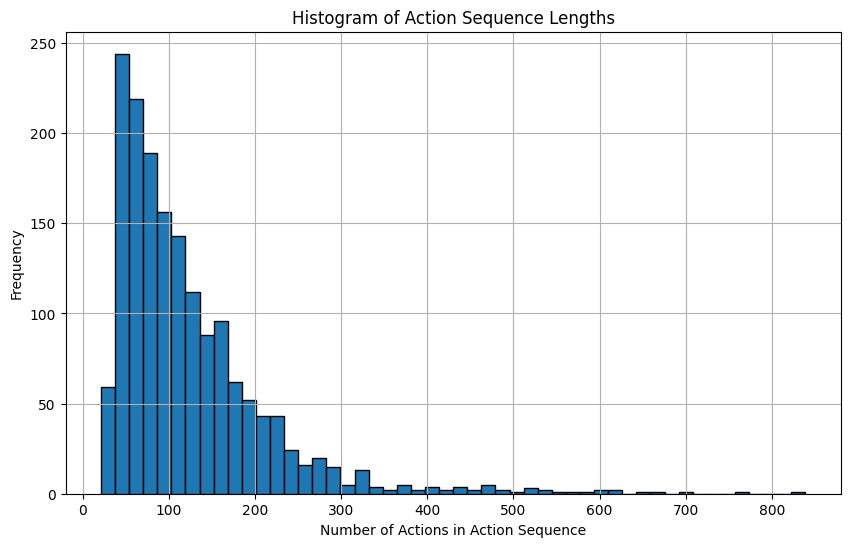

In [24]:
#histogram of action sequence lengths for players who have learned

# Calculate the length of each action_sequence for every ID in final_df
action_lengths = final_df['action_sequences'].apply(len)

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(action_lengths, bins=50, edgecolor='black')
plt.title('Histogram of Action Sequence Lengths')
plt.xlabel('Number of Actions in Action Sequence')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Now i want to look at lengths of action sequences to see where i should trundicate

In [25]:
# Get the length of each action sequence in final_df
action_sequence_lengths = final_df['action_sequences'].apply(len)

# Find the length of the action sequence at the 90th percentile
length_90th_percentile = action_sequence_lengths.quantile(0.99) #quantile is a function that finds the value below which 99% of the data falls
length_95th_percentile = action_sequence_lengths.quantile(0.95)
# Find the percentile of 704 within the dataset, this is the highest value I can process without RAM crashing
percentile_704 = (action_sequence_lengths <= 704).mean()


print(f"The length of the action sequence at the 99th percentile is {length_90th_percentile}.")
print(f"The length of the action sequence at the 95th percentile is {length_95th_percentile}.")
print(f"The action sequence of 704 falls into: {percentile_704}th percentile.")


The length of the action sequence at the 99th percentile is 512.04.
The length of the action sequence at the 95th percentile is 282.5999999999999.
The action sequence of 704 falls into: 0.9987871437234688th percentile.


In [26]:
# Count the number of sequences with lengths greater than 512
sequences_above_512 = (action_sequence_lengths > 512).sum()
sequences_above_283 = (action_sequence_lengths > 282).sum()
sequences_above_704 = (action_sequence_lengths > 704).sum()


print(f"The number of sequences with lengths greater than 512 (99th percentile) is {sequences_above_512}.")
print(f"The number of sequences with lengths greater than 283 (95th percentile) is {sequences_above_283}.")
print(f"The number of sequences with lengths greater than 704 (highest value) is {sequences_above_704}.")



The number of sequences with lengths greater than 512 (99th percentile) is 17.
The number of sequences with lengths greater than 283 (95th percentile) is 83.
The number of sequences with lengths greater than 704 (highest value) is 2.


truncating at 704 since it perserves the most data

In [27]:
# Filter final_df to exclude rows with action_sequences longer than 704. only 2 action sequences will be removed
filtered_final_df = final_df[final_df['action_sequences'].apply(len) <= 704]

# Check the new shape of the DataFrame
print(f"Filtered DataFrame has {filtered_final_df.shape[0]} rows and {filtered_final_df.shape[1]} columns.")


Filtered DataFrame has 1647 rows and 6 columns.
